In [5]:
import subprocess
from collections import OrderedDict
from bs4 import BeautifulSoup as bs

def console(cmnd, cwd='.', show_output=True, raise_error=True):
    try:
        output = subprocess.check_output(
            cmnd, stderr=subprocess.STDOUT, shell=True, cwd=cwd,
            universal_newlines=True)
    except subprocess.CalledProcessError as exc:
        if show_output:
            print("Status : FAIL", exc.returncode, exc.output)
        if raise_error:
            raise Exception("Error")
        return exc.returncode
    else:
        output = output.strip()
        if show_output:
            print("Output: \n{}\n".format(output))
        return output 

def ape(text, attributes='-cdrspp', cwd='APE-master', show_output=True):
    output = console(f'./ape.exe -text "{text}" {attributes}', show_output=show_output, cwd=cwd)
    return output


class Object:
    def __init__(self, idx=None, name=None, func=None, na=None, operator=None, amount=None, inventory=None) -> None:
        self.idx = idx
        self.name = name
        self.func = func
        self.na = na
        self.operator = operator
        self.amount = amount

        self.inventory = inventory or dict()

    def parse(self, s):
        s = s[s.find("(")+1:s.find(")")].split(',')
        self.idx = s[0]
        self.name = s[1]
        self.func = s[2]
        self.na = s[3]
        self.operator = s[4]
        self.amount = int(s[5])


class Predicate:
    def __init__(self, idx=None, action=None, agents=[]) -> None:
        self.idx = idx
        self.action = action
        self.agents = agents
        self.n_agents = len(agents)

    def parse(self, s):
        s = s[s.find("(")+1:s.find(")")].split(',')
        self.idx = s[0]
        self.action = s[1]
        self.agents = s[2:]
        self.n_agents = len(self.agents)


class Relation:
    def __init__(self, agent1=None, link=None, agent2=None) -> None:
        self.agent1 = agent1
        self.link = link
        self.agent2 = agent2

    def parse(self, s):
        s = s[s.find("(")+1:s.find(")")].split(',')
        self.agent1 = s[0]
        self.link = s[1]
        self.agent2 = s[2]


class Query:
    def __init__(self, idx=None, qtype=None, objects=OrderedDict(), predicate=Predicate(), ans='No ans') -> None:
        self.idx = idx
        self.qtype = qtype
        self.objects = objects
        self.predicate = predicate
        
        self.ans = ans


    def parse(self, s):
        s = s[s.find("(")+1:s.find(")")].split(',')
        self.idx = s[0]
        self.qtype = s[1]


class Calc:
    def __init__(self) -> None:
        self.objects = OrderedDict()
        self.predicates = OrderedDict()
        self.relations = OrderedDict()
        self.queries = [Query()]

    def find_next_question(self, lines, i):
        try:
            q_i = lines[i:].index('QUESTION')
            return i + q_i + 1
        except ValueError:
            return 0

    def parse_queries(self, lines, i):
        queries = []
        next_question = self.find_next_question(lines, i)
        while next_question:
            queries.append(self.parse_query(lines[i:next_question]))
            i = next_question
            next_question = self.find_next_question(lines, i)
        queries.append(self.parse_query(lines[i:]))
        return queries

    @staticmethod
    def parse_query(lines):
        q = Query()
        for line in lines:
            if 'query' in line:
                q.parse(line)
            elif 'object' in line:
                ob = Object()
                ob.parse(line)
                q.objects[ob.idx] = ob
            elif 'predicate' in line:
                pr = Predicate()
                pr.parse(line)
                q.predicate = pr
        return q

    def parse_drspp(self, lines):
        for i, line in enumerate(lines):
            if 'object' in line:
                ob = Object()
                ob.parse(line)
                self.objects[ob.idx] = ob
            elif 'predicate' in line:
                pr = Predicate()
                pr.parse(line)
                self.predicates[pr.idx] = pr
            elif 'relation' in line:
                rel = Relation()
                rel.parse(line)
                self.relations[rel.agent1] = rel
            elif 'QUESTION' in line:
                self.queries = self.parse_queries(lines, i+1)
                break

    def ape_lxml(self, text, show_output=False):
        output = ape(text, show_output=show_output)
        soup = bs(output, "lxml")
        lines = soup.find('drspp').text.splitlines()
        lines = [line.strip() for line in lines]
        self.parse_drspp(lines)

    @staticmethod
    def get_ob_name_amount(object):
        ob_name = object.name
        ob_amount = object.amount
        return ob_name, ob_amount

    def action_have(self, objects, pr):
        [a, b] = pr.agents
        ob_name, ob_amount = self.get_ob_name_amount(objects[b])
        inventory = objects[a].inventory
        inventory_i = inventory.get(ob_name, 0)
        inventory[ob_name] = inventory_i + ob_amount
        objects[a].inventory = inventory
        return objects

    def action_give(self, objects, pr):
        [a, b, c] = pr.agents
        ob_name, ob_amount = self.get_ob_name_amount(objects[b])
        inventory_a = objects[a].inventory
        inventory_c = objects[c].inventory
        inventory_ia = inventory_a.get(ob_name, 0) - ob_amount
        inventory_ic = inventory_c.get(ob_name, 0) + ob_amount
        inventory_a[ob_name] = inventory_ia
        inventory_c[ob_name] = inventory_ic
        objects[a].inventory = inventory_a
        objects[c].inventory = inventory_c
        return objects

    def action_take(self, objects, pr):
        [a, b] = pr.agents
        c = self.relations[b].agent2
        ob_name, ob_amount = self.get_ob_name_amount(objects[b])
        inventory_a = objects[a].inventory
        inventory_c = objects[c].inventory
        inventory_ia = inventory_a.get(ob_name, 0) + ob_amount
        inventory_ic = inventory_c.get(ob_name, 0) - ob_amount
        inventory_a[ob_name] = inventory_ia
        inventory_c[ob_name] = inventory_ic
        objects[a].inventory = inventory_a
        objects[c].inventory = inventory_c
        return objects

    def classify_action(self, objects, pr):
        action = pr.action
        if action == 'have':
            objects = self.action_have(objects, pr)
        elif action == 'give':
            objects = self.action_give(objects, pr)
        elif action == 'take':
            objects = self.action_take(objects, pr)
        
        return objects

    def run_predicates(self, objects={}, predicates={}):
        objects = self.objects or objects
        predicates = self.predicates or predicates
        for _, pr in predicates.items():
            objects = self.classify_action(objects, pr)
        self.objects =  objects

    def q_action_have(self, objects, query):
        [a,b] = query.predicate.agents
        ob_name, _ = self.get_ob_name_amount(query.objects[b])
        answer = objects[a].inventory.get(ob_name, 0)
        query.ans = f'{answer} {ob_name}'
        return query.ans

    def q_action_howm(self, objects, query):
        if query.predicate.action == 'have':
            answer = self.q_action_have(objects, query)
        return answer
    
    def run_queries(self, objects=None, queries=None):
        objects = self.objects or objects
        queries = self.queries or queries
        answers = []
        for query in queries:
            if query.qtype == 'howm':
                answers.append(self.q_action_howm(objects, query))
        return answers

    def main(self, text):
        self.ape_lxml(text, show_output=False)
        self.run_predicates()
        answers = self.run_queries()
        for i, answer in enumerate(answers):
            print(f'Q{i}: answer = {answer}')
        return answers

In [30]:
query_line = 'A man has 5 apples. A woman has 0 apples. He gives 2 apples to a woman. How many apples does the woman have? How many apples does the man have?'
C = Calc()
C.main(query_line)
# ape(query_line)

Q0: answer = 2 apple
Q1: answer = 3 apple


['2 apple', '3 apple']

In [31]:
query_line = 'A man has 10 apples. A woman takes 4 apples of the man. How many apples does the woman have? How many apples does the man have?'
C = Calc()
C.main(query_line)

Q0: answer = 4 apple
Q1: answer = 6 apple


['4 apple', '6 apple']

In [32]:
query_line = 'A man has 10 apples. He gives 2 apples to a woman. How many cats does the woman have? How many apples does the man have?'
C = Calc()
C.main(query_line)

Q0: answer = 0 cat
Q1: answer = 8 apple


['0 cat', '8 apple']

In [9]:
import spacy
nlp = spacy.load('en_core_web_sm')
doc = nlp(u'A whole document.\nNo preprocessing require.   Robust to arbitrary formating.')
print(doc)

A whole document.
No preprocessing require.   Robust to arbitrary formating.


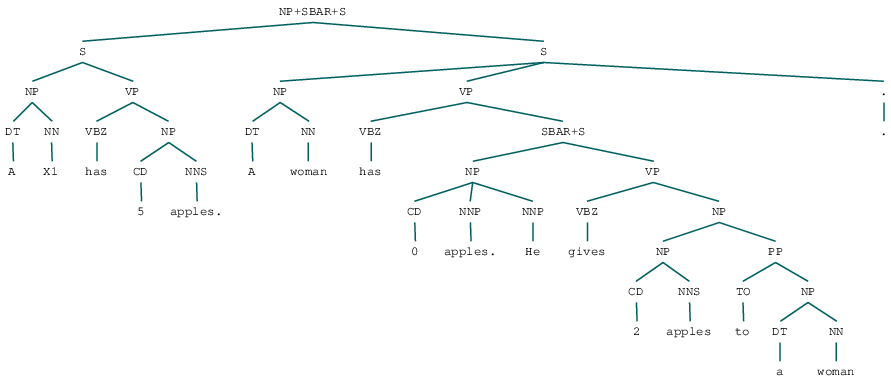

In [10]:
from stat_parser import Parser
parser = Parser()
parser.parse("A X1 has 5 apples. A woman has 0 apples. He gives 2 apples to a woman.")

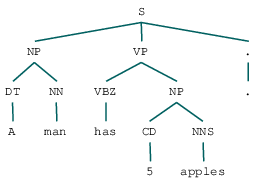

In [12]:
parser.parse("A man has 5 apples.")

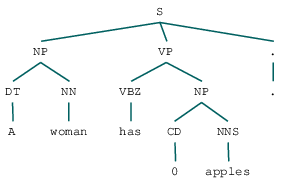

In [13]:
parser.parse("A woman has 0 apples.")

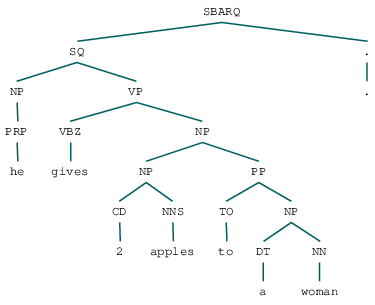

In [14]:
parser.parse("He gives 2 apples to a woman.")

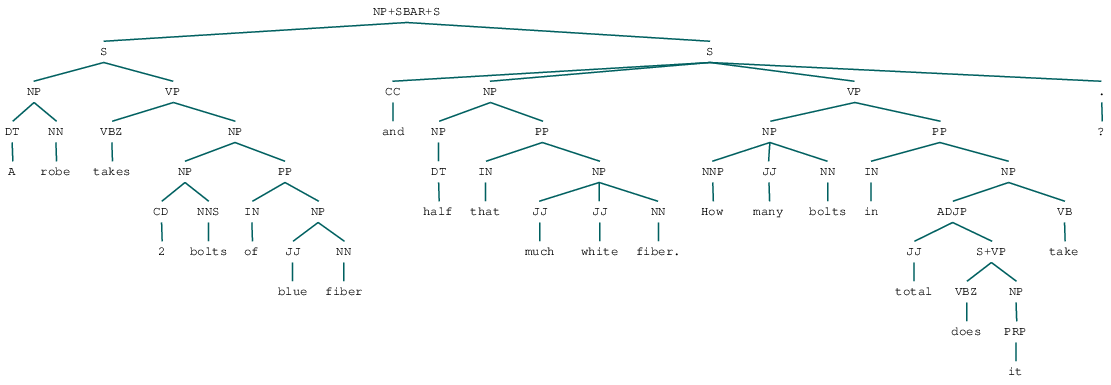

In [15]:
parser.parse('A robe takes 2 bolts of blue fiber and half that much white fiber.  How many bolts in total does it take?')

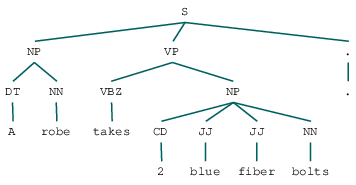

In [18]:
parser.parse('A robe takes 2 blue fiber bolts.')

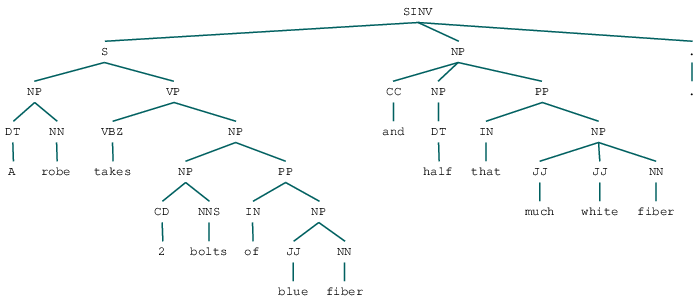

In [19]:
parser.parse('A robe takes 2 bolts of blue fiber and half that much white fiber.')